In [2]:
import numpy as np
import matplotlib.pyplot as plt
import re
from matplotlib.colors import LogNorm
import copy
from hessian import *
from system import *

import glob

import matplotlib
font = {'size'   : 22}

matplotlib.rc('font', **font)

# Dimer

In [12]:
output_files = [x for x in glob.glob("dimer_*_*.molden") if "normal_modes" not in x]
output_files

['dimer_863_866.molden',
 'dimer_869_870.molden',
 'dimer_867_869.molden',
 'dimer_849_851.molden',
 'dimer_846_849.molden',
 'dimer_873_875.molden',
 'dimer_851_854.molden',
 'dimer_858_861.molden',
 'dimer_855_857.molden',
 'dimer_875_878.molden',
 'dimer_879_881.molden',
 'dimer_870_873.molden',
 'dimer_857_858.molden',
 'dimer_861_863.molden',
 'dimer_866_867.molden',
 'dimer_881_846.molden',
 'dimer_854_855.molden',
 'dimer_878_879.molden']

In [15]:
for i in output_files:
    print(i)
    
    dimer_wavenumbers = get_wavenumbers(i)
    dimer_frequencies = wavenumber_to_frequency(dimer_wavenumbers)

    n_atoms = 280
    n_modes = 3 * n_atoms - 6

    Mg1_index = 0
    Mg2_index = 140

    all_displacements = get_all_displacements(i, n_atoms, n_modes)
    rel_displacements = get_all_rel_displacements(i, n_atoms, n_modes, 0, 140)

    sorting_indicies = np.argsort(np.tile(dimer_frequencies, 2))

    np.save(i.replace(".molden", "_hess_frequencies"), np.tile(dimer_frequencies, 2)[sorting_indicies])
    np.save(i.replace(".molden", "_hess_displacements"), np.concatenate((all_displacements[Mg1_index], all_displacements[Mg2_index]))[sorting_indicies])

dimer_863_866.molden
dimer_869_870.molden
dimer_867_869.molden
dimer_849_851.molden
dimer_846_849.molden
dimer_873_875.molden
dimer_851_854.molden
dimer_858_861.molden
dimer_855_857.molden
dimer_875_878.molden
dimer_879_881.molden
dimer_870_873.molden
dimer_857_858.molden
dimer_861_863.molden
dimer_866_867.molden
dimer_881_846.molden
dimer_854_855.molden
dimer_878_879.molden


In [ ]:
fig, ax = plt.subplots(1, 3)

symbols = read_symbols("dimer.xyz")

Mg_indices = np.array([enum for enum, x in enumerate(symbols) if x == "Mg"])
N_indices = np.array([enum for enum, x in enumerate(symbols) if x == "N"])
C_indices = np.array([enum for enum, x in enumerate(symbols) if x == "C"])
O_indices = np.array([enum for enum, x in enumerate(symbols) if x == "O"])
H_indices = np.array([enum for enum, x in enumerate(symbols) if x == "H"])

Mg_avg_disp= all_displacements[Mg_indices].max()
N_avg_disp = all_displacements[N_indices].max()
C_avg_disp = all_displacements[C_indices].max()
O_avg_disp = all_displacements[O_indices].max()
H_avg_disp = all_displacements[H_indices].max()

normalized_displacements = copy.copy(all_displacements)

normalized_displacements[Mg_indices] /= Mg_avg_disp
normalized_displacements[N_indices] /= N_avg_disp
normalized_displacements[C_indices] /= C_avg_disp
normalized_displacements[O_indices] /= O_avg_disp
normalized_displacements[H_indices] /= H_avg_disp

grouped_symbols = np.concatenate((Mg_indices, N_indices, C_indices, O_indices, H_indices))

normalized_displacements = normalized_displacements[grouped_symbols]

bins = np.linspace(0, 0.15, 16)
his = np.histogram(all_displacements[Mg1_index], bins=bins)

ax[0].bar(his[1][1:], his[0], width=0.15/len(bins), align='center')
ax[0].set_xticks(bins[::2])

Mg_displacements = np.where(all_displacements[Mg1_index] > 0.0)[0]

correlation = np.zeros((n_atoms, n_atoms))

for i in Mg_displacements:
    correlation += np.outer(normalized_displacements[:,i], normalized_displacements[:,i])
    
correlation /= len(Mg_displacements)

cax = ax[2].imshow(correlation, origin='lower', cmap=plt.get_cmap('viridis'))#, norm=LogNorm(vmin=0.0001, vmax=20))
    
#fig.colorbar(cax)

# number of each element --  Mg: 2, N: 8, C: 68, O: 8, H: 72
# cumulative -- 2, 10, 78, 86, 158

def ticks(symbols):
    Mg_indices= get_indices(symbols, "Mg")
    N_indices = get_indices(symbols, "N")
    C_indices = get_indices(symbols, "C")
    O_indices = get_indices(symbols, "O")
    H_indices = get_indices(symbols, "H")
    
    lengths = [len(Mg_indices), len(N_indices), len(C_indices), len(O_indices), len(H_indices)]
    
    cumulative = np.cumsum(lengths)
    
    ticks = np.array([x - 0.5 for x in cumulative[:-1]])
    
    return ticks

# number of each element --  Mg: 1, N: 4, C: 55, O: 6, H: 74
# cumulative -- 1, 5, 39, 43, 79

symbol_ticks = ticks(symbols)
symbol_labels= ["N","C","O","H"]

ax[2].set_xticks(symbol_ticks)
ax[2].set_xticklabels(symbol_labels)

ax[2].set_yticks(symbol_ticks)
ax[2].set_yticklabels(symbol_labels)

ax[1].plot(correlation[0])
ax[1].plot(correlation[1])
ax[1].set_xticks(symbol_ticks)
ax[1].set_xticklabels(symbol_labels)

ax[1].vlines(symbol_ticks, color='black', linestyle='--', ymin=0, ymax=max(correlation[0])+0.01, alpha=0.2)
ax[1].set_ylim(0, max(correlation[0])+0.01)

fig.set_size_inches(36,12)

## Chlorophyll-seperation force constant

In [9]:
monomer_symbols, _ = read_xyz("opt_bchla.xyz")
monomer_xyz, _ = get_bchla_in_xy_plane()

phytol_link = monomer_xyz[13]
phytol_link_bond = monomer_xyz[13] - monomer_xyz[12]

trunc_mono_symbols = [monomer_symbols[i] for i in range(len(monomer_symbols)) if i not in phytol_indices()]
trunc_mono_xyz = [monomer_xyz[i] for i in range(len(monomer_xyz)) if i not in phytol_indices()]

trunc_mono_symbols.append("H")
trunc_mono_xyz.append(1.1073 * phytol_link_bond/np.linalg.norm(phytol_link_bond) + monomer_xyz[12])

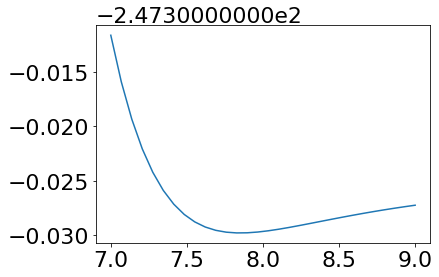

In [60]:
import subprocess
import json

def run_qcore(qcore_str):
    #qcore_path = os.environ["QCORE_PATH"]
    qcore_path="~/qcore/cmake-build-release/bin/qcore"
    json_str = " -n 1 -f json --schema none -s "
    
    json_run = subprocess.run(qcore_path + json_str + qcore_str,
                              shell=True,
                              stdout=subprocess.PIPE,
                              executable="/bin/bash",
                              universal_newlines=True)
    
    json_results = json.loads(json_run.stdout)

    return json_results

def write_qcore_xyz(symbols1, symbols2, xyz1, xyz2):
    
    result = "["
    
    for i in range(len(symbols1)):
        result += f"['{symbols1[i]}', {xyz1[i][0]}, {xyz1[i][1]}, {xyz1[i][2]}],"
        
    for i in range(len(symbols2)):
        result += f"['{symbols2[i]}', {xyz2[i][0]}, {xyz2[i][1]}, {xyz2[i][2]}],"
        
    result = result[:-1]
    
    return result + "]"
    
def run_dimer(symbols1, symbols2, xyz1, xyz2):
    
    qcore_str = f"\"res := xtb(structure(xyz = {write_qcore_xyz(symbols1, symbols2, xyz1, xyz2)}))\""
        
    qcore_res = run_qcore(qcore_str)
    
    return qcore_res["res"]["energy"]
    

distances = np.linspace(7, 9, 30)
    
energies = [run_dimer(trunc_mono_symbols, trunc_mono_symbols, trunc_mono_xyz, trunc_mono_xyz + np.array([0, 0, r])) for r in distances]
                                                                                                                                         
plt.plot(distances, energies) 








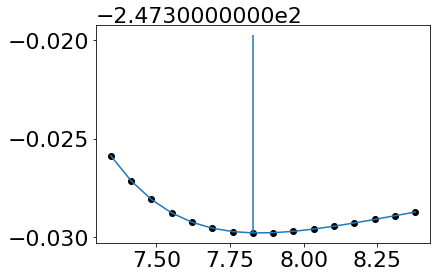

In [67]:
plt.plot(distances[5:21], energies[5:21])
plt.scatter(distances[5:21], energies[5:21], color='black')
plt.vlines([distances[np.argmin(energies)]], ymin=energies[np.argmin(energies)], ymax=energies[np.argmin(energies)]+0.01)

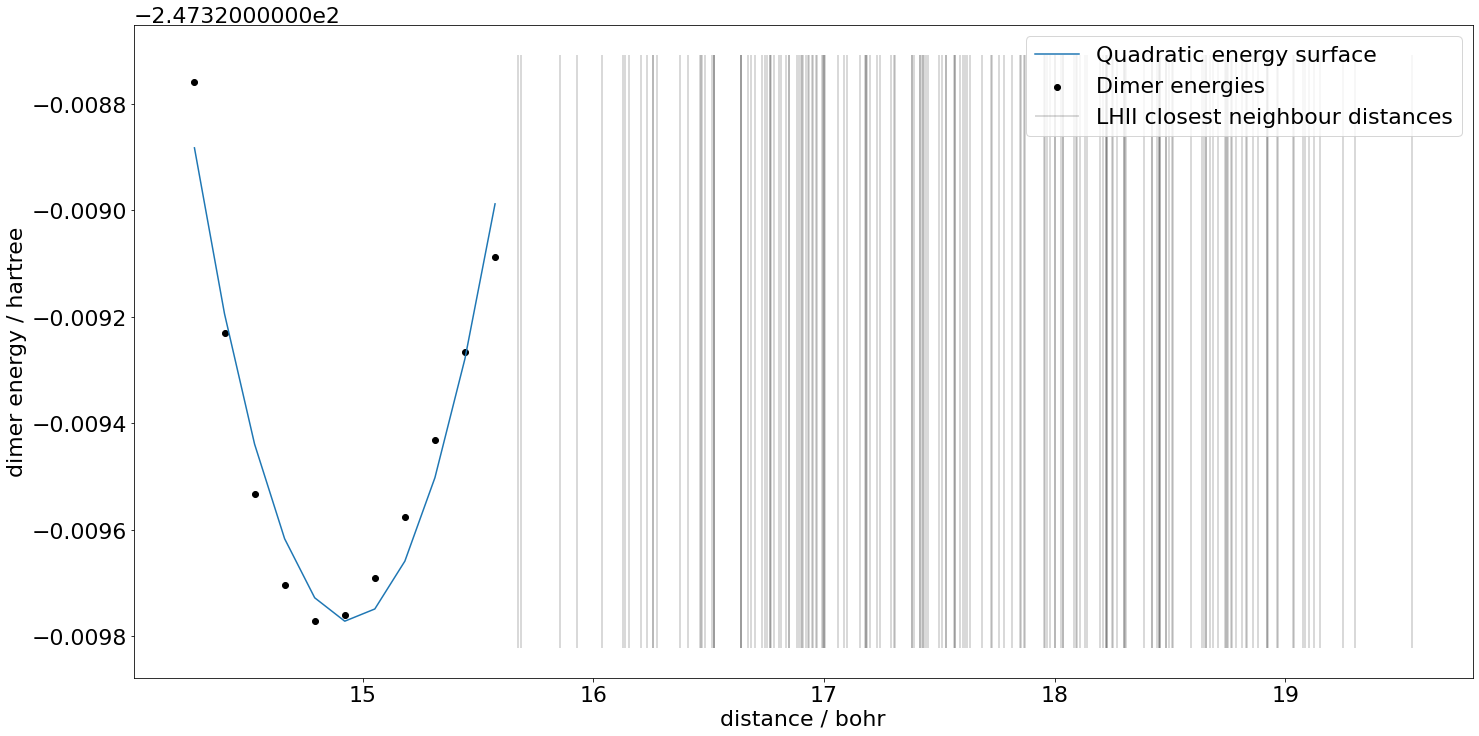

In [108]:
angstrom_to_bohr = 1.88973

b, e = 8, 19

pes = np.polyfit(distances[b:e] * angstrom_to_bohr, energies[b:e], deg=2)

fig, ax = plt.subplots(figsize=(24,12))

ax.plot(distances[b:e] * angstrom_to_bohr, np.polyval(pes, distances[b:e] * angstrom_to_bohr), label="Quadratic energy surface")
ax.scatter(distances[b:e] * angstrom_to_bohr, energies[b:e], color='black', label="Dimer energies")

separations = np.array([9.645428, 9.758968, 9.500993, 9.409923, 9.275155, 9.44757, 9.293411, 9.358246, 9.381873, 9.684332, 8.547988, 8.301905, 8.4300375, 8.535637, 8.389587, 8.294368, 8.487632, 8.711649, 8.864722, 8.714829, 9.764523, 9.882415, 10.012779, 10.187298, 10.344897, 10.0376425, 9.931586, 9.643662, 9.540864, 9.600545, 8.828233, 8.947451, 8.742963, 8.575602, 8.540652, 8.854599, 8.837927, 8.9938, 8.942698, 8.939773, 9.525244, 9.3198, 9.50241, 9.583706, 9.656438, 9.5685215, 9.668668, 9.595325, 9.577603, 9.868756, 9.222453, 9.330186, 9.313869, 9.157238, 9.397316, 9.259941, 9.221567, 9.042349, 8.990819, 8.805701, 9.645409, 9.871773, 9.7672615, 9.636977, 9.544973, 9.526602, 9.4264345, 9.658359, 9.981452, 9.9414015, 8.744536, 8.684143, 8.589086, 8.871623, 9.150515, 9.158644, 9.379222, 8.954106, 8.664863, 8.874205, 10.10868, 10.120451, 10.098872, 10.21385, 10.035712, 9.991409, 9.643656, 9.780661, 9.729605, 9.747884, 8.971671, 8.961091, 9.094, 8.997254, 8.8819065, 9.202519, 9.198464, 9.090094, 9.216575, 9.078662, 9.955379, 9.838676, 9.786803, 9.768098, 9.574675, 9.295913, 9.457719, 9.794041, 9.797657, 9.923949, 8.716246, 8.612765, 8.739252, 8.744491, 8.914837, 8.8608055, 9.028041, 8.959726, 9.1986265, 9.32455, 10.014449, 10.072871, 9.965248, 9.965907, 9.864242, 9.921743, 9.686269, 9.688517, 9.545096, 9.50799, 8.723992, 8.804534, 8.909506, 8.896827, 8.945321, 8.820775, 8.934008, 8.968439, 8.914685, 8.87268, 9.780104, 9.749294, 9.872091, 9.928812, 10.135093, 10.074627, 9.888231, 9.765687, 9.900964, 9.915622, 9.093399, 9.267017, 9.274882, 9.446061, 9.216861, 8.996702, 9.124772, 8.996759, 8.603055, 8.603985, 9.918812, 9.684164, 9.296882, 8.981165, 9.117225, 9.455649, 9.5140915, 9.628902, 10.011652, 10.094535, 8.976768, 8.892341, 9.093454, 9.307885, 9.230395, 9.100831, 9.22521, 9.233937, 9.048462, 8.805831])

ymin, ymax = ax.get_ylim()

ax.vlines(separations * angstrom_to_bohr, ymin=ymin, ymax=ymax, alpha=0.2, color='black', label="LHII closest neighbour distances")

ax.set_xlabel("distance / bohr")
ax.set_ylabel("dimer energy / hartree")
ax.legend()

In [89]:
masses = {"Mg" : 24.305, "H" : 1.00784, "C" : 12.0107, "N" : 14.0067, "O" : 15.999}

mass = np.sum([masses[s] for s in trunc_mono_symbols])
mass

588.9738399999999

In [98]:
reduced_mass = (mass*mass)/(mass + mass)

angular_freq = np.sqrt(pes[0]/reduced_mass) # atomic units
normal_freq = angular_freq / (2 * np.pi)
fs_normal_freq = normal_freq * 2.4188843265857e-17 * 1e15 # atomic time * s/atomic time * fs/s
fs_normal_freq

9.956278546459048e-06